In [1]:
# Install wheels package in order to use correct version
!pip install ../input/mrcnn-wheels/grpcio-1.32.0-cp37-cp37m-manylinux2014_x86_64.whl --no-deps
!pip install ../input/mrcnn-wheels/gast-0.3.3-py2.py3-none-any.whl --no-deps
!pip install ../input/mrcnn-wheels/six-1.15.0-py2.py3-none-any.whl --no-deps
!pip install ../input/mrcnn-wheels/tensorflow_estimator-2.4.0-py2.py3-none-any.whl --no-deps
!pip install ../input/mrcnn-wheels/h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl --no-deps
!pip install ../input/mrcnn-wheels/typing_extensions-3.7.4.3-py3-none-any.whl --no-deps
!pip install ../input/mrcnn-wheels/tensorflow-2.4.0-cp37-cp37m-manylinux2010_x86_64.whl --no-deps
!pip install ../input/mrcnn-wheels/Keras-2.4.0-py2.py3-none-any.whl --no-deps

Processing /kaggle/input/mrcnn-wheels/grpcio-1.32.0-cp37-cp37m-manylinux2014_x86_64.whl
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling grpcio-1.43.0:
      Successfully uninstalled grpcio-1.43.0
Processing /kaggle/input/mrcnn-wheels/gast-0.3.3-py2.py3-none-any.whl
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
Processing /kaggle/input/mrcnn-wheels/six-1.15.0-py2.py3-none-any.whl
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
Processing /kaggle/input/mrcnn-wheels/tensorflow_estimator-2.4.0-py2.py3-none-any.whl
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
Processing /kaggle/input/mrcnn-wheel

In [2]:
import sys
sys.path.append('../input/sartorius-instance-segmentation/sartorius-maskrcnn/sartorius-maskrcnn/Mask_RCNN')

In [3]:
import matplotlib.pyplot as plt
import mrcnn.utils as utils
import mrcnn.model as modellib
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import sys
import json
import time
import skimage
import imageio
import glob

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from PIL import Image, ImageEnhance
from mrcnn.config import Config
from mrcnn import visualize


seed=42
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

test_fol = '../input/sartorius-cell-instance-segmentation/test'
sub = pd.read_csv('../input/sartorius-cell-instance-segmentation/sample_submission.csv')

print('Tensorflow version: ', tf.__version__)
print('TF Keras version: ', tf.keras.__version__)

2022-06-20 14:51:15.629046: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Tensorflow version:  2.4.0
TF Keras version:  2.4.0


In [4]:
# Image Dimension
HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

# Image target dimension, divisible by 64
HEIGHT_TARGET = 576
WIDTH_TARGET = 704
SHAPE_TARGET = (HEIGHT_TARGET, WIDTH_TARGET)
BATCH_SIZE = 1

train = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')

# Unique Cell Names
CELL_NAMES = np.sort(train['cell_type'].unique())
print(f'CELL_NAMES: {CELL_NAMES}')

# Make Mark-RCNN a pixel confidence mask instead of a binary mask
PIXEL_CONFIDENCE_MASKS = True

CELL_NAMES: ['astro' 'cort' 'shsy5y']


## <font color='green'/> **Utility functions**

In [5]:
# Run Length Encode an instance
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    img = unpad_image(img)
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [6]:
# Removes the padding from an image
def unpad_image(image):
    offset_h = (HEIGHT_TARGET - HEIGHT) // 2
    offset_w = (WIDTH_TARGET - WIDTH) // 2
    
    return image[offset_h:offset_h+HEIGHT, offset_w:offset_w+WIDTH]

# Func. to pad images and masks
def pad_image(image, constant_values):
    pad_h = (HEIGHT_TARGET - HEIGHT) // 2
    pad_w = (WIDTH_TARGET - WIDTH) // 2
    
    if len(image.shape) == 3:
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), constant_values=constant_values)
    else:
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), constant_values=constant_values)

In [7]:
def fix_overlap(msk):
    """
    Args:
        mask: multi-channel mask, each channel is an instance of cell, shape:(520,704,None)
    Returns:
        multi-channel mask with non-overlapping values, shape:(520,704,None)
    """
    msk = np.array(msk)
    msk = np.pad(msk, [[0,0],[0,0],[1,0]])
    ins_len = msk.shape[-1]
    msk = np.argmax(msk,axis=-1)
    msk = tf.keras.utils.to_categorical(msk, num_classes=ins_len)
    msk = msk[...,1:]
    msk = msk[...,np.any(msk, axis=(0,1))]
    return msk

def check_overlap(msk):
    msk = msk.astype(np.bool).astype(np.uint8) # binary mask
    return np.any(np.sum(msk, axis=-1)>1) # only one channgel will contain value

## <font color='green'/>**Load test data**

In [8]:
!rm -rf './test'
!mkdir './test'

In [9]:
# Create padded images with contrast enhancement
for file_path in tqdm(glob.glob('/kaggle/input/sartorius-cell-instance-segmentation/test/*.png')):
    # ReadImage
    image = imageio.imread(file_path)
    # Pad Image
    image = pad_image(image, 128)
    
    # Create "RGB" image by stacking the image 3 times
    image = np.stack((image, image, image), axis=2)
    
    # Write image to working directory
    image_id = file_path.split('/')[-1].split('.')[0]
    imageio.imwrite(f'test/{image_id}.png', image)

  0%|          | 0/3 [00:00<?, ?it/s]

## <font color='green'/> **Set configuration**

In [10]:
class InferenceConfig(Config):
    
    NAME = 'sartorius-cell'
    
    # Set batch size to 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = BATCH_SIZE
    
    # No. classes
    NUM_CLASSES = 1 + len(CELL_NAMES)
    
    # Image dimensions
    IMAGE_RESIZE_MODE = "none"
    IMAGE_MIN_DIM = HEIGHT_TARGET
    IMAGE_MAX_DIM = WIDTH_TARGET
    IMAGE_SHAPE = [HEIGHT_TARGET, WIDTH_TARGET, 3]
    
    # Mini mask
    USE_MINI_MASK = False
    
    # Dataloader Queue Size (was set to 100 but resulted in OOM error)
    MAX_QUEUE_SIZE = 10
    
    # Regions of Interest
    PRE_NMS_LIMIT = 6000
    
    # Non Max Supression
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    
    # Instances
    MAX_GT_INSTANCES = 790
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 400
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  704
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  576
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [576 704   3]
INITIAL_EPOCH                  0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE            

## <font color='green'/> **Initialize model and load weight**

In [11]:
# Create model in training mode
!mkdir 'model_checkpoints'
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='model_checkpoints')

# Load weight
model_path = '../input/sartorius-weight/mask_rcnn_l2reg-and-head_0030.h5'

print(f'Loading weights from: {model_path}')
model.load_weights(model_path, by_name=True)
print('Load successfully!!!')

2022-06-20 14:51:31.047645: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-20 14:51:31.048904: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-20 14:51:31.095158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 14:51:31.095952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-06-20 14:51:31.096040: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-06-20 14:51:31.122411: I tensorflow/stream_executor/platform/def

Loading weights from: ../input/sartorius-weight/mask_rcnn_l2reg-and-head_0030.h5


2022-06-20 14:51:35.229587: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 14:51:35.230192: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-20 14:51:35.230823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 14:51:35.231954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-06-20 14:5

Load successfully!!!


## <font color='green'/> **Predict**

In [12]:
def plot_prediction(img, r):
    visualize.display_instances(
        img,
        r['rois'],
        r['masks'],
        r['class_ids'],
        ['BG'] + CELL_NAMES.tolist(),
        r['scores'],
        figsize=(16,16)
    )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-06-20 14:51:40.959424: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-06-20 14:51:41.738140: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-06-20 14:51:41.750214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is saf

Overlap found!!!
Image id:  d8bfd1dafdc4


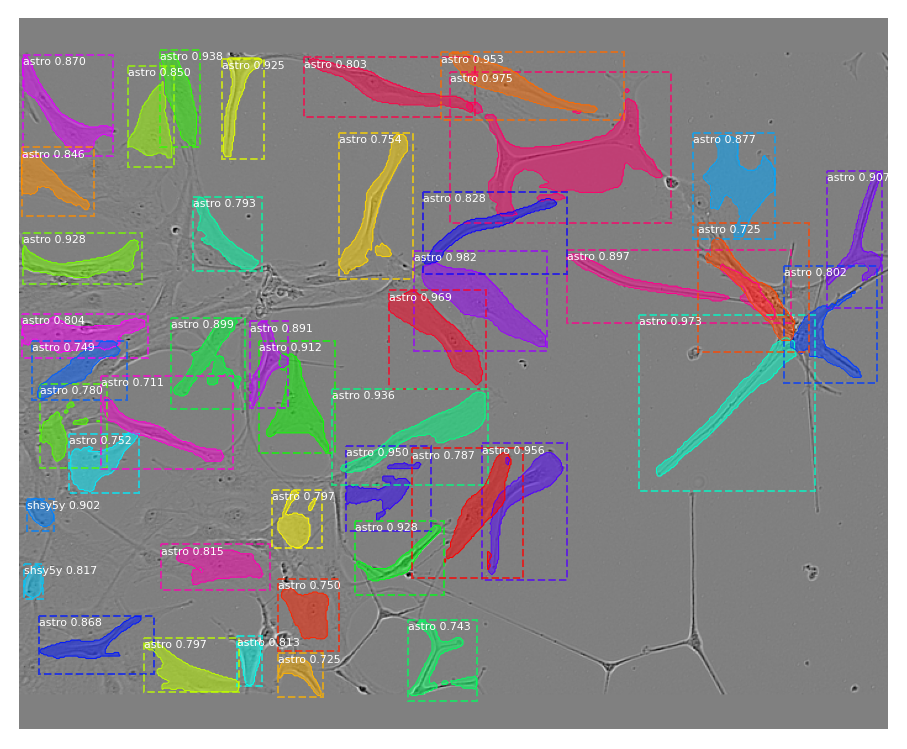

Overlap found!!!
Image id:  7ae19de7bc2a


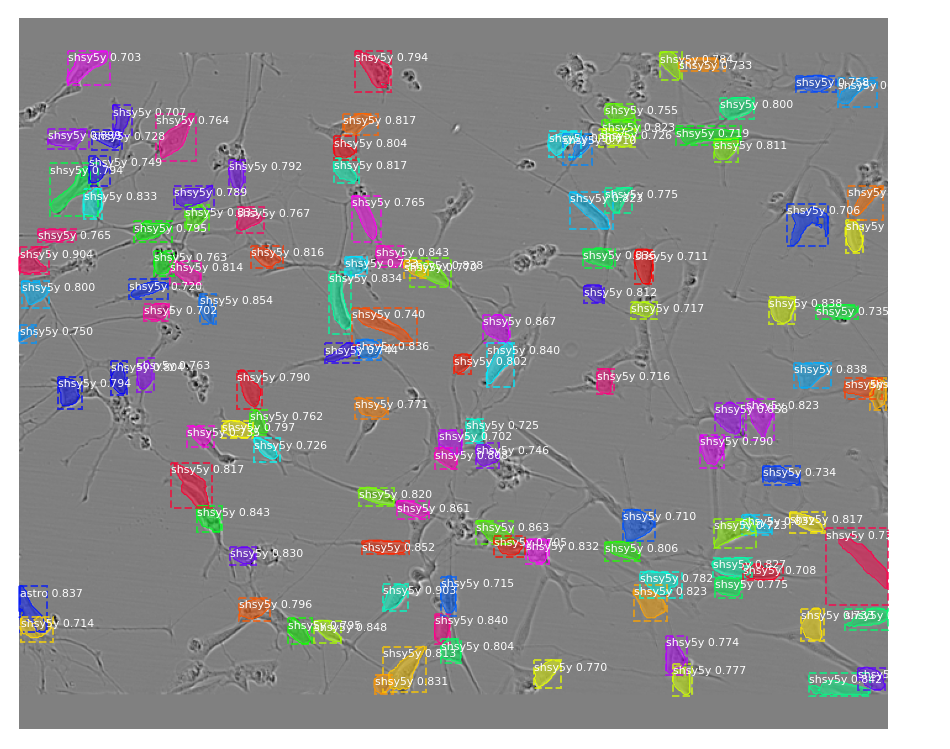

Overlap found!!!
Image id:  d48ec7815252


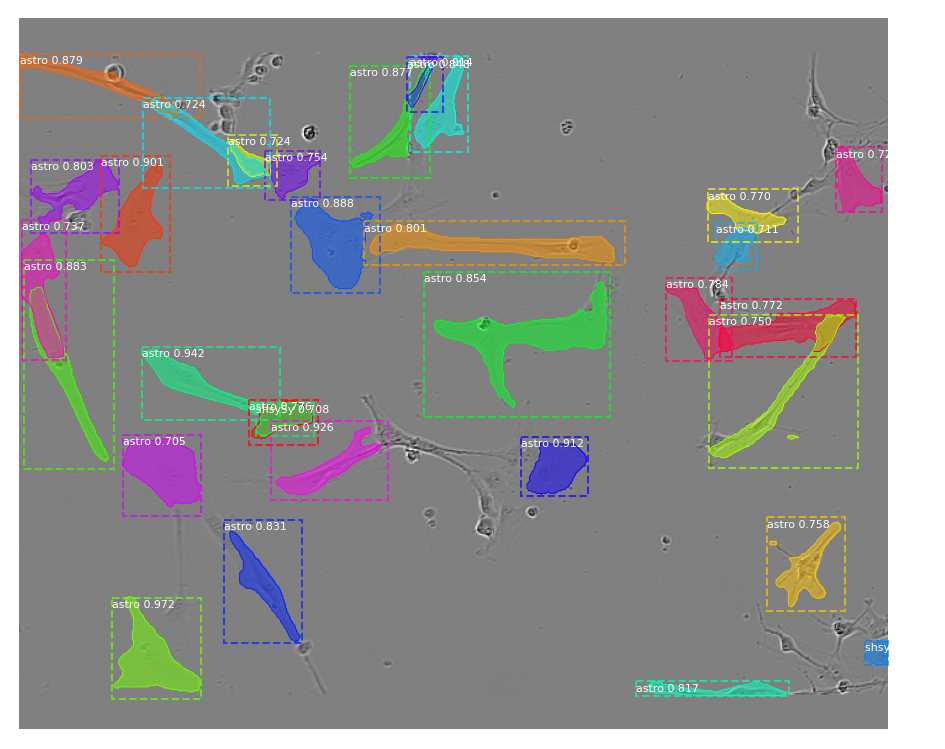

In [13]:
img_names, pred_annots = [], []

for img_file in glob.glob('./test/*.png'):
    img_name, pred_annot = [], []
    img_id = img_file.split('/')[-1].split('.')[0]
    
    # Load img
    img = imageio.imread(img_file)
    
    # Convert to 3 channels
    if img.ndim != 3:
        img = np.stack([img, img, img], axis=-1)
        
    # Preprocess test data similar to train data
    #mold_img = modellib.mold_image(img, config)
        
    # Detect
    result = model.detect([img])[0]
    r = result
    
    pred_masks = result['masks']
    
    if pred_masks.shape[-1] == 0:
        img_name.append(img_id)
        pred_annot.append('')
    else:
        if check_overlap(pred_masks):
            print('Overlap found!!!')
            pred_masks = fix_overlap(pred_masks)
        for i in range(pred_masks.shape[-1]):
            pred_mask = pred_masks[..., i].astype(np.uint8)
            img_name.append(img_id)
            pred_annot.append(rle_encode(pred_mask))
    
    img_names.extend(img_name)
    pred_annots.extend(pred_annot)
    
    # Plot prediction
    print('Image id: ', img_id)
    plot_prediction(img, result)

In [14]:
pd.DataFrame({'id': img_names, 'predicted': pred_annots}).sort_values(['id']).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head(20)

,id,predicted
0,7ae19de7bc2a,172135 6 172837 9 173540 10 174243 12 174947 1...
1,7ae19de7bc2a,48835 2 49538 4 50241 7 50945 8 51649 9 52352 ...
2,7ae19de7bc2a,142708 10 143411 14 144114 17 144818 18 145522...
3,7ae19de7bc2a,25924 12 26625 17 27327 20 28029 23 28731 25 2...
4,7ae19de7bc2a,130243 7 130257 1 130947 15 131651 15 132355 1...
5,7ae19de7bc2a,209963 6 210665 13 211367 17 212071 19 212774 ...
6,7ae19de7bc2a,311362 4 312062 10 312763 14 313465 18 314167 ...
7,7ae19de7bc2a,176787 1 177489 4 178193 4 178896 5 179600 5 1...
8,7ae19de7bc2a,322655 1 323358 4 324061 6 324765 7 325469 8 3...
9,7ae19de7bc2a,64822 2 65525 4 66226 7 66930 1 66933 5 67634 ...
